<a href="https://colab.research.google.com/github/My1stK8s/skillfactoryds/blob/master/Diplom/diplom_nba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install tabnet
!pip install pytorch_tabnet
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 210 kB 67.1 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 112 kB 38.5 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 149 kB 58.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5abcc152e29c8ba592bfb202a40c8c3a8bf752404acd0f306f55480d92e750e8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

MessageError: ignored

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import  XGBClassifier
import torch
import optuna
from optuna import Trial, visualization
from pytorch_tabnet.tab_model import TabNetClassifier
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix,roc_auc_score,confusion_matrix,accuracy_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import requests
import pandas as pd
import os
from tqdm import tqdm
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from xgboost import XGBClassifier

In [ ]:

games_header = {
    'user-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/57.0.2987.133 Safari/537.36',
    'Dnt': '1',
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en',
    'origin': 'http://stats.nba.com',
    'Referer': 'https://github.com'
}

data_headers = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Safari/605.1.15',
    'Accept-Language': 'en-us',
    'Referer': 'https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2019-20&SeasonType=Regular%20Season',
    'Connection': 'keep-alive',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

todays_games_url = 'https://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2021/scores/00_todays_scores.json'


data_url = 'https://stats.nba.com/stats/leaguedashteamstats?' \
           'Conference=&DateFrom=&DateTo=&Division=&GameScope=&' \
           'GameSegment=&LastNGames=0&LeagueID=00&Location=&' \
           'MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&' \
           'PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&' \
           'PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&' \
           'Season=2021-22&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&' \
           'StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='



def get_json_data(url):
    raw_data = requests.get(url, headers=data_headers)
    json = raw_data.json()
    return json.get('resultSets')


def get_todays_games_json(url):
    raw_data = requests.get(url, headers=games_header)
    json = raw_data.json()
    return json.get('gs').get('g')


def to_data_frame(data):
    data_list = data[0]
    return pd.DataFrame(data=data_list.get('rowSet'), columns=data_list.get('headers'))


def create_todays_games(input_list):
    games = []
    for game in input_list:
        home = game.get('h')
        away = game.get('v')
        home_team = home.get('tc') + ' ' + home.get('tn')
        away_team = away.get('tc') + ' ' + away.get('tn')
        games.append([home_team, away_team])
    return games

def createTodaysGames(games, df):
    match_data = []
    for game in games:
        home_team = game[0]
        away_team = game[1]
        home_team_series = df.iloc[team_index_current.get(home_team)]
        away_team_series = df.iloc[team_index_current.get(away_team)]
        stats = home_team_series.append(away_team_series)
        match_data.append(stats)

    games_data_frame = pd.concat(match_data, ignore_index=True, axis=1)
    games_data_frame = games_data_frame.T

    frame_ml = games_data_frame.drop(columns=['TEAM_ID', 'CFID', 'CFPARAMS', 'TEAM_NAME'])
    frame_ml['Date'] = "02-05-2021-22"
    frame_ml = preproc(frame_ml)
    frame_ml.drop(columns=['Date'],inplace=True)
    
    data = frame_ml.values
    data = data.astype(float)

    return data,frame_ml,games_data_frame

# Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
summary = pd.DataFrame(index = metrics)
def metrics(summary,col,y_test,y_pred):
    values = [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred),]
    summary[col] = values
    return summary

# Confusion matrix
def conf_mat(y_test, y_pred):
    P = np.sum(y_test==1)
    N = np.sum(y_test==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(tp, fp) 
    print(fn, tn)

# Date preproc
def preproc(X):
    data= X['Date'].str.split('-',expand=True)
    data.columns=['month','day','year','end_year']
    X = pd.concat([X,data],axis = 1)
    X['month'] = X['month'].astype(int)
    X['day'] = X['day'].astype(int)
    X['year'] = X['year'].astype(int)
    X['end_year'] = X['end_year'].astype(int)
    return X

In [ ]:
# На  протяжении  всех  сезонов  команды меняли названия заполним их что б  правильно  получить данные !
team_codes = {
    'Atlanta': 'Atlanta Hawks',
    'NewJersey': 'New Jersey Nets',
    'Boston': 'Boston Celtics',
    'Brooklyn': 'Brooklyn Nets',
    'Charlotte': 'Charlotte Bobcats',
    'Chicago': 'Chicago Bulls',
    'Cleveland': 'Cleveland Cavaliers',
    'Dallas': 'Dallas Mavericks',
    'Denver': 'Denver Nuggets',
    'Detroit': 'Detroit Pistons',
    'GoldenState': 'Golden State Warriors',
    'Houston': 'Houston Rockets',
    'Indiana': 'Indiana Pacers',
    'LAClippers': 'Los Angeles Clippers',
    'LALakers': 'Los Angeles Lakers',
    'Memphis': 'Memphis Grizzlies',
    'Miami': 'Miami Heat',
    'Milwaukee': 'Milwaukee Bucks',
    'Minnesota': 'Minnesota Timberwolves',
    'NewOrleans': 'New Orleans Pelicans',
    'NewYork': 'New York Knicks',
    'OklahomaCity': 'Oklahoma City Thunder',
    'Seattle': 'Seattle SuperSonics',
    'Orlando': 'Orlando Magic',
    'Philadelphia': 'Philadelphia 76ers',
    'Phoenix': 'Phoenix Suns',
    'Portland': 'Portland Trail Blazers',
    'Sacramento': 'Sacramento Kings',
    'SanAntonio': 'San Antonio Spurs',
    'Toronto': 'Toronto Raptors',
    'Utah': 'Utah Jazz',
    'Washington': 'Washington Wizards',
}

team_index_07 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Charlotte Bobcats': 2,
    'Chicago Bulls': 3,
    'Cleveland Cavaliers': 4,
    'Dallas Mavericks': 5,
    'Denver Nuggets': 6,
    'Detroit Pistons': 7,
    'Golden State Warriors': 8,
    'Houston Rockets': 9,
    'Indiana Pacers': 10,
    'Los Angeles Clippers': 11,
    'Los Angeles Lakers': 12,
    'Memphis Grizzlies': 13,
    'Miami Heat': 14,
    'Milwaukee Bucks': 15,
    'Minnesota Timberwolves': 16,
    'New Jersey Nets': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Orlando Magic': 20,
    'Philadelphia 76ers': 21,
    'Phoenix Suns': 22,
    'Portland Trail Blazers': 23,
    'Sacramento Kings': 24,
    'San Antonio Spurs': 25,
    'Seattle SuperSonics': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_08 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Charlotte Bobcats': 2,
    'Chicago Bulls': 3,
    'Cleveland Cavaliers': 4,
    'Dallas Mavericks': 5,
    'Denver Nuggets': 6,
    'Detroit Pistons': 7,
    'Golden State Warriors': 8,
    'Houston Rockets': 9,
    'Indiana Pacers': 10,
    'Los Angeles Clippers': 11,
    'Los Angeles Lakers': 12,
    'Memphis Grizzlies': 13,
    'Miami Heat': 14,
    'Milwaukee Bucks': 15,
    'Minnesota Timberwolves': 16,
    'New Jersey Nets': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_12 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Bobcats': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_13 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Bobcats': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_14 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Bobcats': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_current = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Hornets': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'LA Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

In [ ]:
#Парсинг статистики  всех  команд  за  все  сезоны

url = 'https://stats.nba.com/stats/' \
      'leaguedashteamstats?Conference=&' \
      'DateFrom=10%2F29%2F{2}&DateTo={0}%2F{1}%2F{3}' \
      '&Division=&GameScope=&GameSegment=&LastNGames=0&' \
      'LeagueID=00&Location=&MeasureType=Base&Month=0&' \
      'OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&' \
      'PerMode=PerGame&Period=0&PlayerExperience=&' \
      'PlayerPosition=&PlusMinus=N&Rank=N&' \
      'Season={4}' \
      '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&' \
      'StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='

year = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
season = ["2007-08", "2008-09","2009-10", "2010-11", "2011-12", "2012-13", "2013-14", "2014-15", "2015-16", "2016-17",
          "2017-18", "2018-19","2019-20", "2020-21", "2021-22"]
month = [ 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

begin_year_pointer = year[0]
end_year_pointer = year[0]
count = 0
year_count = 0

for season1 in tqdm(season):
    for month1 in tqdm(month):
        if month1 == 1:
            count += 1
            end_year_pointer = year[count]

        for day1 in tqdm(days):
            try:
                general_data = settings.get_json_data(
                    url.format(month1, day1, begin_year_pointer, end_year_pointer, season1))
                general_df = settings.to_data_frame(general_data)
                general_df['Date'] = str(month1) + '-' + str(day1) + '-' + season1

                directory2 = os.fsdecode('./data')
                name = directory2 + '/' + str(month1) + '-' + str(day1) + '-' + season1 + '.xlsx'
                general_df.to_excel(name)
            except:
                continue
    year_count += 1
    begin_year_pointer = year[count]



In [ ]:
# cкачаем  ручками  результаты  всех  сезонов  NBA - https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba/nbaoddsarchives.htm
# обработаем  их  ,уберем лишнее, и соединим со  статистикой для  обучения с  подкреплением 
directory = os.fsdecode('../preprocessing/data/odds-data/filthy-odds-data')

for file in tqdm(os.listdir(directory)):
    filename = os.fsdecode(file)
    year = filename[9:-5]
    if filename.endswith('.xlsx'):
        df = pd.read_excel(directory + '/' + filename)
        x = pd.DataFrame(columns=['Date', 'Home', 'Away', 'OU', 'Spread', 'ML_Home', 'ML_Away', 'Points', 'Win_Margin'])
        count = 2
        date = ''
        home = ''
        away = ''
        ou = ''
        spread = ''
        ml_home = ''
        ml_away = ''
        points = ''
        margin = ''
        for row in df.itertuples():
            if count % 2 == 0:
                if len(str(row[1])) == 3:
                    date = str(year + '-' + '0' + str(row[1]))
                else:
                    date = str(year + '-' + str(row[1]))
                away = team_codes.get(str(row[4]))
                if row[10] == 'pk':
                    ou = 0
                else:
                    ou = row[10]
                points = row[9]
                ml_away = str(row[12])
                count += 1
            else:
                home = team_codes.get(str(row[4]))
                if row[10] == 'pk':
                    spread = 0
                else:
                    spread = row[10]
                if spread > 50:
                    temp = spread
                    spread = ou
                    ou = temp
                ml_home = str(row[12])
                margin = row[9] - points
                points += row[9]
                temp = {
                    'Date': date,
                    'Home': home,
                    'Away': away,
                    'OU': ou,
                    'Spread': spread,
                    'ML_Home': ml_home,
                    'ML_Away': ml_away,
                    'Points': points,
                    'Win_Margin': margin
                }
                x = x.append(temp, ignore_index=True)
                count += 1
                date = ''
                home = ''
                away = ''
                ou = ''
                spread = ''
                ml_home = ''
                ml_away = ''
                points = ''
                margin = ''
        directory2 = os.fsdecode('../preprocessing/data/odds-data/clean-odds-data')
        name = directory2 + '/' + year + '.xlsx'
        x.to_excel(name)


In [ ]:
# Создаем дата сет - произведем конкатенацию  команд  с их  статистикой  и их  результатами 
season_array = ["2007-08", "2008-09", "2009-10", "2010-11", "2011-12", "2012-13", "2013-14", "2014-15", "2015-16",
                "2016-17", "2017-18", "2018-19", "2019-20", "2020-21","2021-22"]

            odds_directory = os.fsdecode('Odds-Data/Odds-Data-Clean')
df = pd.DataFrame
scores = []
win_margin = []
OU = []
OU_Cover = []
games = []
for season in tqdm(season_array):
    file = pd.read_excel(odds_directory + '/' + '{}.xlsx'.format(season))

    team_data_directory = os.fsdecode('../../Team-Data/{}'.format(season))

    for row in file.itertuples():
        home_team = row[3]
        away_team = row[4]

        date = row[2]
        date_array = date.split('-')
        year = date_array[0] + '-' + date_array[1]
        month = date_array[2][:2]
        day = date_array[2][2:]

        if month[0] == '0':
            month = month[1:]
        if day[0] == '0':
            day = day[1:]

        team_data_file = month + '-' + day + '-' + year + '.xlsx'

        data_frame = pd.read_excel(team_data_directory + '/' + team_data_file)

        if len(data_frame.index) == 30:
            scores.append(row[9])
            OU.append(row[5])
            if row[10] > 0:
                win_margin.append(1)
            else:
                win_margin.append(0)
            print(row[5])

            if row[9] < row[5]:
                OU_Cover.append(0)
            elif row[9] > row[5]:
                OU_Cover.append(1)
            elif row[9] == row[5]:
                OU_Cover.append(2)
            if season == '2007-08':
                home_team_series = data_frame.iloc[team_index_07.get(home_team)]
                away_team_series = data_frame.iloc[team_index_07.get(away_team)]
            elif season == '2008-09' or season == "2009-10" or season == "2010-11" or season == "2011-12":
                home_team_series = data_frame.iloc[team_index_08.get(home_team)]
                away_team_series = data_frame.iloc[team_index_08.get(away_team)]
            elif season == "2012-13":
                home_team_series = data_frame.iloc[team_index_12.get(home_team)]
                away_team_series = data_frame.iloc[team_index_12.get(away_team)]
            elif season == '2013-14':
                home_team_series = data_frame.iloc[team_index_13.get(home_team)]
                away_team_series = data_frame.iloc[team_index_13.get(away_team)]
            else:
                home_team_series = data_frame.iloc[team_index_14.get(home_team)]
                away_team_series = data_frame.iloc[team_index_14.get(away_team)]

            game = home_team_series.append(away_team_series)
            games.append(game)
season = pd.concat(games, ignore_index=True, axis=1)
season = season.T

frame = season.drop(columns=['TEAM_ID', 'CFID', 'CFPARAMS', 'Unnamed: 0'])
frame['Score'] = np.asarray(scores)
frame['Home-Team-Win'] = np.asarray(win_margin)
frame['OU'] = np.asarray(OU)
frame['OU-Cover'] = np.asarray(OU_Cover)
frame.to_csv('Data/allseasons2007-22.csv')


IndentationError: unexpected indent (Temp/ipykernel_13112/2739932872.py, line 5)

In [ ]:
# pip install pytorch_tabnet
torch.cuda.is_available()

False

In [ ]:
# Загружаем данные
df = pd.read_csv('Data/allseasons2007-22.csv')
df.drop(['Score',  'Unnamed: 0', 'TEAM_NAME', 'TEAM_NAME.1', 'Date.1', 'OU-Cover', 'OU','TEAM_ID','TEAM_ID.1'],
          axis=1, inplace=True)
df.drop_duplicates(keep=False)

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,...,FT_PCT.1,OREB.1,DREB.1,REB.1,AST.1,TOV.1,STL.1,BLK.1,BLKA.1,PF.1,PFD.1,PTS.1,PLUS_MINUS.1,GP_RANK.1,W_RANK.1,L_RANK.1,W_PCT_RANK.1,MIN_RANK.1,FGM_RANK.1,FGA_RANK.1,FG_PCT_RANK.1,FG3M_RANK.1,FG3A_RANK.1,FG3_PCT_RANK.1,FTM_RANK.1,FTA_RANK.1,FT_PCT_RANK.1,OREB_RANK.1,DREB_RANK.1,REB_RANK.1,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,0.375,22.0,43.0,0.512,17.0,24.0,41.0,20.0,19.0,12.0,7.0,8.0,23.0,32.0,102.0,3.0,24,8,1,1,5,15,27,5,20,20,15,10,1,29,...,0.639,16.0,30.0,46.0,18.0,17.0,5.5,6.0,8.0,30.0,22.5,91.0,-11.0,2,20,23,20,5,14,7,20,25,21,24,28,27,27,4,20,10,26,20,23,10,24,30,15,26,24,1
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,0.500,24.0,34.0,0.706,9.5,28.5,38.0,15.5,11.0,3.5,5.5,6.0,21.0,25.5,97.0,-2.5,2,8,12,12,5,29,28,21,3,13,3,7,5,19,...,0.767,10.5,32.5,43.0,20.5,12.5,8.5,6.0,3.0,18.5,21.0,103.5,17.5,2,2,1,1,5,15,26,6,17,18,14,8,11,11,17,14,15,16,6,12,10,3,2,21,9,3,0
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,0.455,22.0,28.5,0.772,13.5,39.5,53.0,21.0,15.5,10.5,9.5,7.5,25.5,22.5,103.0,5.5,2,2,1,1,1,21,6,25,3,7,8,10,13,8,...,0.464,11.0,36.5,47.5,18.5,18.0,5.5,6.5,8.5,18.5,16.0,82.5,-6.5,2,20,23,20,5,24,8,26,12,25,4,30,29,30,13,6,9,24,23,23,7,27,2,30,30,19,1
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,0.341,25.0,29.5,0.847,11.0,30.0,41.0,21.5,18.0,6.5,6.5,4.0,26.5,24.5,90.5,-14.0,2,8,12,12,1,30,28,29,9,7,17,4,12,3,...,0.909,8.0,29.0,37.0,25.5,11.5,9.0,4.5,7.5,19.5,19.5,106.0,23.0,2,2,1,1,5,5,16,3,1,14,1,21,28,1,26,22,26,3,3,9,24,22,7,22,4,1,0
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,0.267,25.0,31.0,0.806,14.0,38.0,52.0,20.0,15.0,6.0,4.0,10.0,23.0,25.0,101.0,7.0,24,8,1,1,5,20,21,15,26,21,27,4,9,6,...,0.822,6.0,31.0,37.0,18.5,13.0,5.0,9.0,3.0,21.0,22.0,93.0,5.5,2,8,12,12,5,25,30,14,17,10,23,16,19,4,29,18,26,24,7,25,3,3,10,18,24,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,0.353,14.1,19.1,0.741,11.3,34.9,46.2,27.5,12.5,7.5,5.3,5.4,17.5,18.4,110.5,-0.8,10,23,24,24,12,2,1,14,27,28,13,30,28,26,...,0.809,8.6,33.6,42.2,22.8,12.1,8.0,5.4,4.5,19.3,19.1,107.2,1.5,22,9,7,10,3,19,26,12,29,29,16,2,9,5,30,23,30,23,1,8,5,11,13,18,20,11,0
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,0.329,16.1,20.8,0.773,9.2,34.4,43.6,24.0,12.7,7.0,3.8,3.6,19.6,20.1,105.5,3.1,5,9,11,11,14,24,27,19,17,11,25,18,19,16,...,0.733,13.3,34.7,48.0,24.9,13.3,10.2,6.4,6.3,19.2,19.2,111.4,3.7,1,3,4,3,24,5,2,18,28,24,24,15,6,29,1,13,1,10,10,1,1,30,12,15,7,6,1
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,0.347,14.6,18.8,0.780,8.9,34.2,43.1,27.2,13.2,7.0,4.0,5.0,19.1,19.3,108.5,1.3,22,12,11,12,10,10,17,7,10,9,17,29,30,10,...,0.781,10.2,32.3,42.4,22.4,14.8,7.8,4.7,5.0,21.5,20.4,102.7,-9.5,10,29,29,29,12,29,15,29,22,13,28,7,8,9,16,29,29,27,25,9,21,20,29,3,28,30,1
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,0.344,16.0,21.0,0.758,12.5,32.7,45.1,24.5,14.9,8.5,5.6,5.5,22.2,20.3,111.3,0.6,10,17,17,18,4,11,4,24,3,1,20,21,15,22,...,0.832,10.1,35.1,45.2,26.1,14.3,7.1,5.4,5.0,20.2,19.4,113.4,3.5,22,4,3,4,10,3,11,1,26,27,12,4,13,1,18,8,11,6,21,21,7,21,27,13,2,8,1


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

Using cpu


In [ ]:
#разобьем данные о Дате на  колонки и добавим  в датасет 
dd = preproc(df) 


In [ ]:
dd

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,...,AST.1,TOV.1,STL.1,BLK.1,BLKA.1,PF.1,PFD.1,PTS.1,PLUS_MINUS.1,GP_RANK.1,W_RANK.1,L_RANK.1,W_PCT_RANK.1,MIN_RANK.1,FGM_RANK.1,FGA_RANK.1,FG_PCT_RANK.1,FG3M_RANK.1,FG3A_RANK.1,FG3_PCT_RANK.1,FTM_RANK.1,FTA_RANK.1,FT_PCT_RANK.1,OREB_RANK.1,DREB_RANK.1,REB_RANK.1,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win,month,day,year,end_year
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,0.375,22.0,43.0,0.512,17.0,24.0,41.0,20.0,19.0,12.0,7.0,8.0,23.0,32.0,102.0,3.0,24,8,1,1,5,15,27,5,20,20,15,10,1,29,...,18.0,17.0,5.5,6.0,8.0,30.0,22.5,91.0,-11.0,2,20,23,20,5,14,7,20,25,21,24,28,27,27,4,20,10,26,20,23,10,24,30,15,26,24,1,11,2,2007,8
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,0.500,24.0,34.0,0.706,9.5,28.5,38.0,15.5,11.0,3.5,5.5,6.0,21.0,25.5,97.0,-2.5,2,8,12,12,5,29,28,21,3,13,3,7,5,19,...,20.5,12.5,8.5,6.0,3.0,18.5,21.0,103.5,17.5,2,2,1,1,5,15,26,6,17,18,14,8,11,11,17,14,15,16,6,12,10,3,2,21,9,3,0,11,2,2007,8
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,0.455,22.0,28.5,0.772,13.5,39.5,53.0,21.0,15.5,10.5,9.5,7.5,25.5,22.5,103.0,5.5,2,2,1,1,1,21,6,25,3,7,8,10,13,8,...,18.5,18.0,5.5,6.5,8.5,18.5,16.0,82.5,-6.5,2,20,23,20,5,24,8,26,12,25,4,30,29,30,13,6,9,24,23,23,7,27,2,30,30,19,1,11,2,2007,8
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,0.341,25.0,29.5,0.847,11.0,30.0,41.0,21.5,18.0,6.5,6.5,4.0,26.5,24.5,90.5,-14.0,2,8,12,12,1,30,28,29,9,7,17,4,12,3,...,25.5,11.5,9.0,4.5,7.5,19.5,19.5,106.0,23.0,2,2,1,1,5,5,16,3,1,14,1,21,28,1,26,22,26,3,3,9,24,22,7,22,4,1,0,11,2,2007,8
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,0.267,25.0,31.0,0.806,14.0,38.0,52.0,20.0,15.0,6.0,4.0,10.0,23.0,25.0,101.0,7.0,24,8,1,1,5,20,21,15,26,21,27,4,9,6,...,18.5,13.0,5.0,9.0,3.0,21.0,22.0,93.0,5.5,2,8,12,12,5,25,30,14,17,10,23,16,19,4,29,18,26,24,7,25,3,3,10,18,24,11,1,11,2,2007,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,0.353,14.1,19.1,0.741,11.3,34.9,46.2,27.5,12.5,7.5,5.3,5.4,17.5,18.4,110.5,-0.8,10,23,24,24,12,2,1,14,27,28,13,30,28,26,...,22.8,12.1,8.0,5.4,4.5,19.3,19.1,107.2,1.5,22,9,7,10,3,19,26,12,29,29,16,2,9,5,30,23,30,23,1,8,5,11,13,18,20,11,0,1,23,2021,22
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,0.329,16.1,20.8,0.773,9.2,34.4,43.6,24.0,12.7,7.0,3.8,3.6,19.6,20.1,105.5,3.1,5,9,11,11,14,24,27,19,17,11,25,18,19,16,...,24.9,13.3,10.2,6.4,6.3,19.2,19.2,111.4,3.7,1,3,4,3,24,5,2,18,28,24,24,15,6,29,1,13,1,10,10,1,1,30,12,15,7,6,1,1,23,2021,22
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,0.347,14.6,18.8,0.780,8.9,34.2,43.1,27.2,13.2,7.0,4.0,5.0,19.1,19.3,108.5,1.3,22,12,11,12,10,10,17,7,10,9,17,29,30,10,...,22.4,14.8,7.8,4.7,5.0,21.5,20.4,102.7,-9.5,10,29,29,29,12,29,15,29,22,13,28,7,8,9,16,29,29,27,25,9,21,20,29,3,28,30,1,1,23,2021,22
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,0.344,16.0,21.0,0.758,12.5,32.7,45.1,24.5,14.9,8.5,5.6,5.5,22.2,20.3,111.3,0.6,10,17,17,18,4,11,4,24,3,1,20,21,15,22,...,26.1,14.3,7.1,5.4,5.0,20.2,19.4,113.4,3.5,22,4,3,4,10,3,11,1,26,27,12,4,13,1,18,8,11,6,21,21,7,21,27,13,2,8,1,1,23,2021,22


In [ ]:
dd.drop(columns=["Date"],inplace=True)

In [ ]:
dd

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,...,AST.1,TOV.1,STL.1,BLK.1,BLKA.1,PF.1,PFD.1,PTS.1,PLUS_MINUS.1,GP_RANK.1,W_RANK.1,L_RANK.1,W_PCT_RANK.1,MIN_RANK.1,FGM_RANK.1,FGA_RANK.1,FG_PCT_RANK.1,FG3M_RANK.1,FG3A_RANK.1,FG3_PCT_RANK.1,FTM_RANK.1,FTA_RANK.1,FT_PCT_RANK.1,OREB_RANK.1,DREB_RANK.1,REB_RANK.1,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win,month,day,year,end_year
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,0.375,22.0,43.0,0.512,17.0,24.0,41.0,20.0,19.0,12.0,7.0,8.0,23.0,32.0,102.0,3.0,24,8,1,1,5,15,27,5,20,20,15,10,1,29,...,18.0,17.0,5.5,6.0,8.0,30.0,22.5,91.0,-11.0,2,20,23,20,5,14,7,20,25,21,24,28,27,27,4,20,10,26,20,23,10,24,30,15,26,24,1,11,2,2007,8
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,0.500,24.0,34.0,0.706,9.5,28.5,38.0,15.5,11.0,3.5,5.5,6.0,21.0,25.5,97.0,-2.5,2,8,12,12,5,29,28,21,3,13,3,7,5,19,...,20.5,12.5,8.5,6.0,3.0,18.5,21.0,103.5,17.5,2,2,1,1,5,15,26,6,17,18,14,8,11,11,17,14,15,16,6,12,10,3,2,21,9,3,0,11,2,2007,8
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,0.455,22.0,28.5,0.772,13.5,39.5,53.0,21.0,15.5,10.5,9.5,7.5,25.5,22.5,103.0,5.5,2,2,1,1,1,21,6,25,3,7,8,10,13,8,...,18.5,18.0,5.5,6.5,8.5,18.5,16.0,82.5,-6.5,2,20,23,20,5,24,8,26,12,25,4,30,29,30,13,6,9,24,23,23,7,27,2,30,30,19,1,11,2,2007,8
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,0.341,25.0,29.5,0.847,11.0,30.0,41.0,21.5,18.0,6.5,6.5,4.0,26.5,24.5,90.5,-14.0,2,8,12,12,1,30,28,29,9,7,17,4,12,3,...,25.5,11.5,9.0,4.5,7.5,19.5,19.5,106.0,23.0,2,2,1,1,5,5,16,3,1,14,1,21,28,1,26,22,26,3,3,9,24,22,7,22,4,1,0,11,2,2007,8
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,0.267,25.0,31.0,0.806,14.0,38.0,52.0,20.0,15.0,6.0,4.0,10.0,23.0,25.0,101.0,7.0,24,8,1,1,5,20,21,15,26,21,27,4,9,6,...,18.5,13.0,5.0,9.0,3.0,21.0,22.0,93.0,5.5,2,8,12,12,5,25,30,14,17,10,23,16,19,4,29,18,26,24,7,25,3,3,10,18,24,11,1,11,2,2007,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,0.353,14.1,19.1,0.741,11.3,34.9,46.2,27.5,12.5,7.5,5.3,5.4,17.5,18.4,110.5,-0.8,10,23,24,24,12,2,1,14,27,28,13,30,28,26,...,22.8,12.1,8.0,5.4,4.5,19.3,19.1,107.2,1.5,22,9,7,10,3,19,26,12,29,29,16,2,9,5,30,23,30,23,1,8,5,11,13,18,20,11,0,1,23,2021,22
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,0.329,16.1,20.8,0.773,9.2,34.4,43.6,24.0,12.7,7.0,3.8,3.6,19.6,20.1,105.5,3.1,5,9,11,11,14,24,27,19,17,11,25,18,19,16,...,24.9,13.3,10.2,6.4,6.3,19.2,19.2,111.4,3.7,1,3,4,3,24,5,2,18,28,24,24,15,6,29,1,13,1,10,10,1,1,30,12,15,7,6,1,1,23,2021,22
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,0.347,14.6,18.8,0.780,8.9,34.2,43.1,27.2,13.2,7.0,4.0,5.0,19.1,19.3,108.5,1.3,22,12,11,12,10,10,17,7,10,9,17,29,30,10,...,22.4,14.8,7.8,4.7,5.0,21.5,20.4,102.7,-9.5,10,29,29,29,12,29,15,29,22,13,28,7,8,9,16,29,29,27,25,9,21,20,29,3,28,30,1,1,23,2021,22
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,0.344,16.0,21.0,0.758,12.5,32.7,45.1,24.5,14.9,8.5,5.6,5.5,22.2,20.3,111.3,0.6,10,17,17,18,4,11,4,24,3,1,20,21,15,22,...,26.1,14.3,7.1,5.4,5.0,20.2,19.4,113.4,3.5,22,4,3,4,10,3,11,1,26,27,12,4,13,1,18,8,11,6,21,21,7,21,27,13,2,8,1,1,23,2021,22


In [ ]:
# подготовим данные  для  обучени  поделим для  эксперемента на разные  части 

In [ ]:
train3000 = dd[15000:18000]
X3000 = train3000.drop(['Home-Team-Win'], axis=1).values
y3000 = train3000['Home-Team-Win'].values

In [ ]:
# test  all 279 next match
test279 = dd[18000:18279]
X279 = test279.drop(['Home-Team-Win'],axis=1).values
y279 =  test279['Home-Team-Win'].values


In [ ]:
train18000=dd[:18000]
X18000 = train18000.drop(['Home-Team-Win'], axis=1).values
y18000 = train18000['Home-Team-Win'].values

In [ ]:
X18000.shape,y18000.shape,X3000.shape,y3000.shape,X279.shape,y279.shape

((18000, 108), (18000,), (3000, 108), (3000,), (279, 108), (279,))

In [ ]:
# Построим нашу нейросеть на  табличных  данных "Tabnet"

In [ ]:
# наивная модель последние  2 сезона 

In [ ]:
clfn3000 = TabNetClassifier(verbose=0)
clfn3000.fit(X_train=X3000, y_train=y3000)  

No early stopping will be performed, last training weights will be used.


In [ ]:
# метрики предсказания для 3000 игр
y_pred3000 = clfn3000.predict(X3000)
metrics(summary,'clfn3000',y3000,y_pred3000),conf_mat(y3000, y_pred3000)

Positive: 1659, Negative: 1341
966 359
693 982


(           clfn3000
 accuracy   0.649333
 precision  0.729057
 recall     0.582278
 f1_score   0.647453, None)

In [ ]:
# тест 279 последних  игр
y_pred279 = clfn3000.predict(X279)
metrics(summary,'clfn3000-279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
84 38
69 88


(           clfn3000  clfn3000-279
 accuracy   0.649333      0.616487
 precision  0.729057      0.688525
 recall     0.582278      0.549020
 f1_score   0.647453      0.610909, None)

In [ ]:
# наивная модель все сезоны 

In [ ]:
clfn18000 = TabNetClassifier(verbose=0)
clfn18000.fit(X_train=X18000, y_train=y18000)  

No early stopping will be performed, last training weights will be used.


In [ ]:
# тест 18000 последних  игр
y_pred18000 = clfn18000.predict(X18000)
metrics(summary,'clfn18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)

Positive: 10594, Negative: 7406
8706 3031
1888 4375


(           clfn3000  clfn3000-279  clfn18000
 accuracy   0.649333      0.616487   0.726722
 precision  0.729057      0.688525   0.741757
 recall     0.582278      0.549020   0.821786
 f1_score   0.647453      0.610909   0.779723, None)

In [ ]:
# тест 18000 последних  игр
y_pred279 = clfn18000.predict(X279)
metrics(summary,'clfn18000-279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
107 57
46 69


(           clfn3000  clfn3000-279  clfn18000  clfn18000-279
 accuracy   0.649333      0.616487   0.726722       0.630824
 precision  0.729057      0.688525   0.741757       0.652439
 recall     0.582278      0.549020   0.821786       0.699346
 f1_score   0.647453      0.610909   0.779723       0.675079, None)

In [ ]:
#  так  как результаты  оказались  лучше  на всей   выборке  матчей будем  работать с ними !

In [ ]:
# поиск гиперпараметров Tabnet c проверкой  KFold
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_d = trial.suggest_int("n_d", 4, 64, step=1)
    n_a = trial.suggest_int("n_a", 4, 64, step=1)
    n_steps = trial.suggest_int("n_steps", 2, 10, step=1)
    gamma = trial.suggest_float("gamma", 0.8, 2, step=0.1)
    n_shared = trial.suggest_int("n_shared", 1, 10, step=1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    
    tabnet_params = dict(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="max",
                                           # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=2e-2,
                                           factor=0.5,
                                           ),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     device_name = DEVICE,
                     verbose=0,
                     ) #early stopping
    kfs = KFold(n_splits=10,random_state=42,shuffle=True)
    CV_score_array=[]
    for train_index, test_index in kfs.split(X18000,y18000):
        X_train, X_valid = X18000[train_index], X18000[test_index]
        y_train, y_valid = y18000[train_index], y18000[test_index]
        clf = TabNetClassifier(**tabnet_params)
        clf.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience= 50,
                  max_epochs=trial.suggest_int('epochs', 250,300, step = 50),
                  batch_size=2048,
                  virtual_batch_size = 47 ,  
                  eval_metric=['accuracy'], 
                  num_workers=0,
                  weights=1,
                  drop_last=False)
        CV_score_array.append(clf.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [ ]:
study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60)


[I 2022-02-03 21:09:34,763] A new study created in memory with name: TabNet optimization



Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_accuracy = 0.71833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 80 and best_val_0_accuracy = 0.70444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 92 and best_val_0_accuracy = 0.70278
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 91 and best_val_0_accuracy = 0.71111
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 21 and best_val_0_accuracy = 0.7
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 41 and best_val_0_accuracy = 0.715
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 217 with best_epoch = 167 and best_val_0_accuracy = 0.70333
Best weights from best epoch are automa

[I 2022-02-03 23:43:45,792] Trial 0 finished with value: 0.7056111111111111 and parameters: {'mask_type': 'entmax', 'n_d': 28, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3, 'n_shared': 9, 'lambda_sparse': 1.6016541518387349e-06, 'epochs': 300}. Best is trial 0 with value: 0.7056111111111111.


In [ ]:
TabNet_params = study.best_params
print(TabNet_params)

{'mask_type': 'entmax', 'n_d': 28, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3, 'n_shared': 9, 'lambda_sparse': 1.6016541518387349e-06, 'epochs': 300}


In [ ]:
# {'mask_type': 'entmax', 'n_d': 28, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3, 'n_shared': 9, 'lambda_sparse': 1.6016541518387349e-06, 'epochs': 300}


In [ ]:
# обучение на  всем дата сете с результатами лучших гиперпараметров
final_params = dict(
    mask_type=TabNet_params['mask_type'],
    n_d=TabNet_params['n_d'],
    n_a=TabNet_params['n_a'],
    n_steps=TabNet_params['n_steps'],
    gamma=TabNet_params['gamma'],
    lambda_sparse=TabNet_params['lambda_sparse'],
    n_shared=TabNet_params['n_shared'],
    optimizer_fn=torch.optim.Adam)
clf = TabNetClassifier(**final_params,verbose=0)
clf.fit(X_train=X18000, y_train=y18000,
        max_epochs=TabNet_params['epochs'],
        patience= 50,
        batch_size=2048,
        virtual_batch_size=47)

No early stopping will be performed, last training weights will be used.


In [ ]:
# тест 18000  игр
y_pred18000 = clf.predict(X18000)
metrics(summary,'clf18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)

Positive: 10594, Negative: 7406
8877 2976
1717 4430


(           clfn3000  clfn3000-279  clfn18000  clfn18000-279  clf18000
 accuracy   0.649333      0.616487   0.726722       0.630824  0.739278
 precision  0.729057      0.688525   0.741757       0.652439  0.748924
 recall     0.582278      0.549020   0.821786       0.699346  0.837927
 f1_score   0.647453      0.610909   0.779723       0.675079  0.790930, None)

In [ ]:
# тест 279 последних  игр
y_pred279 = clf.predict(X279)
metrics(summary,'clf18000-279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
113 58
40 68


(           clfn3000  clfn3000-279  ...  clf18000  clf18000-279
 accuracy   0.649333      0.616487  ...  0.739278      0.648746
 precision  0.729057      0.688525  ...  0.748924      0.660819
 recall     0.582278      0.549020  ...  0.837927      0.738562
 f1_score   0.647453      0.610909  ...  0.790930      0.697531
 
 [4 rows x 6 columns], None)

In [ ]:
# результаты  улучшились сохраняем  модель 
saved_filename = clf.save_model('tabnet')
clf = TabNetClassifier()
clf.load_model('tabnet.zip')

Successfully saved model at /content/drive/MyDrive/data/tabnet.zip


In [ ]:
# Теперь  построим несколько ML моделей ("catboost",'Xgboost') и произведем  сразвнение 

In [ ]:
# наивная модель CatBoostClassifier
X_train,X_valid, y_train, y_valid = train_test_split(X18000, y18000, test_size=0.2)
cbmn = CatBoostClassifier()
cbmn.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

In [ ]:
# тест 18000  игр
y_pred18000 = cbmn.predict(X18000)
# y_pred18000 = np.rint(y_pred18000)
metrics(summary,'cbmn18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)

Positive: 10594, Negative: 7406
8678 2999
1916 4407


(           clfn3000  clfn3000-279  clfn18000  ...  clf18000  clf18000-279  cbmn18000
 accuracy   0.649333      0.616487   0.726722  ...  0.739278      0.648746   0.726944
 precision  0.729057      0.688525   0.741757  ...  0.748924      0.660819   0.743170
 recall     0.582278      0.549020   0.821786  ...  0.837927      0.738562   0.819143
 f1_score   0.647453      0.610909   0.779723  ...  0.790930      0.697531   0.779309
 
 [4 rows x 7 columns], None)

In [ ]:
# тест 279 последних  игр
y_pred279 = cbmn.predict(X279)

metrics(summary,'cbmn279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
107 53
46 73


(           clfn3000  clfn3000-279  clfn18000  ...  clf18000-279  cbmn18000   cbmn279
 accuracy   0.649333      0.616487   0.726722  ...      0.648746   0.726944  0.645161
 precision  0.729057      0.688525   0.741757  ...      0.660819   0.743170  0.668750
 recall     0.582278      0.549020   0.821786  ...      0.738562   0.819143  0.699346
 f1_score   0.647453      0.610909   0.779723  ...      0.697531   0.779309  0.683706
 
 [4 rows x 8 columns], None)

In [ ]:
# поиск гиперпараметров CatBoostClassifier c проверкой  KFold
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method",['Newton','Gradient']),
        "verbose": False}

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    '''cross-validation'''
    kf = KFold(n_splits=10,random_state=42,shuffle = True)
    CV_score_array =[]
    for train_index, test_index in kf.split(X18000,y18000):
        X_train, X_valid = X18000[train_index], X18000[test_index]
        y_train, y_valid = y18000[train_index], y18000[test_index]
        cbc = CatBoostClassifier(**param)
        cbc.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        preds = cbc.predict(X_valid)
        # pred_labels = np.rint(preds)
        accuracy = accuracy_score(y_valid, preds)

        CV_score_array.append(accuracy)
    avg = np.mean(CV_score_array)

    return avg

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-02-04 00:58:12,794] A new study created in memory with name: no-name-6fd6df35-181f-407e-a878-4ae244fe07e0
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-02-04 01:00:32,696] Trial 0 finished with value: 0.7046111111111112 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.012498206365648218, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'leaf_estimation_method': 'Newton'}. Best is trial 0 with value: 0.7046111111111112.
[I 2022-02-04 01:05:07,145] Trial 1 finished with value: 0.7064444444444444 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0981639976784009, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'leaf_estimation_method': 'Newton'}. Best is trial 1 with value: 0.7064444444444444.
[I 2022-02-04 01:15:06,732] Trial 2 finished with value: 0.706388888888889 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07956551343981516, 'dep

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 3
Best trial:
  Value: 0.7064444444444444
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.0981639976784009
    depth: 10
    boosting_type: Plain
    bootstrap_type: MVS
    leaf_estimation_method: Newton


In [ ]:
# обучение на  всем дата сете с результатами лучших гиперпараметров
X_train,X_valid, y_train, y_valid = train_test_split(X18000, y18000, test_size=0.2)
fcbm = CatBoostClassifier(**trial.params)
fcbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

In [ ]:
# сохраняем  модель 
fcbm.save_model("catboost")
catboost = CatBoostClassifier()

catboost.load_model("catboost")


In [ ]:
# тест 18000   игр
y_pred18000 = fcbm.predict(X18000)
metrics(summary,'fcbm18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)


In [ ]:
# тест 279 последних  игр
y_pred279 = fcbm.predict(X279)
metrics(summary,'fcbm279',y279,y_pred279),conf_mat(y279, y_pred279)

In [ ]:
# поиск гиперпараметров XGBClassifier с проверкой  cross validation
def objective(trial: Trial,X,y) -> float:
    param = {   'objective': 'multi:softprob',
                "n_estimators" : trial.suggest_int('n_estimators', 0, 100),
                "num_class" :  2,
                'max_depth': 2,
                'eta': 0.01,
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                # 'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
            }
    
    model = XGBClassifier(**param)
    
    return cross_val_score(model, X, y, cv=10).mean()

In [ ]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X18000,y18000),n_trials= 50)

In [ ]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.7059444444444445,
params {'n_estimators': 31, 'reg_alpha': 0, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 0, 'colsample_bytree': 0.99}


In [ ]:
# обучение на  всем дата сете с результатами лучших гиперпараметров
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X18000, y18000)
xgbc = xgb.XGBClassifier(**study.best_trial.params)
xgbc.fit(X18000, y18000)


XGBClassifier(colsample_bytree=0.99, min_child_weight=2, n_estimators=31,
              reg_lambda=3)

In [ ]:
# тест 18000 игр
y_pred18000 = xgbc.predict(X18000)
metrics(summary,'xgbc18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)


Positive: 10594, Negative: 7406
8532 3046
2062 4360


(           clf18000  clf18000-279  fcbm18000   fcbm279  xgbc18000   xgbc279
 accuracy   0.739278      0.648746   0.713778  0.645161   0.716222  0.655914
 precision  0.748924      0.660819   0.730985  0.660714   0.736915  0.666667
 recall     0.837927      0.738562   0.812819  0.725490   0.805362  0.745098
 f1_score   0.790930      0.697531   0.769733  0.691589   0.769619  0.703704,
 None)

In [ ]:
# тест 279 последних  игр
y_pred279 = xgbc.predict(X279)
metrics(summary,'xgbc279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
114 57
39 69


(           clf18000  clf18000-279  fcbm18000   fcbm279  xgbc18000   xgbc279
 accuracy   0.739278      0.648746   0.713778  0.645161   0.716222  0.655914
 precision  0.748924      0.660819   0.730985  0.660714   0.736915  0.666667
 recall     0.837927      0.738562   0.812819  0.725490   0.805362  0.745098
 f1_score   0.790930      0.697531   0.769733  0.691589   0.769619  0.703704,
 None)

In [ ]:
# Сохраняем  модель 
xgbc.save_model("/content/drive/MyDrive/data/xgbc.json")
xgbc = xgb.Booster()
xgbc.load_model('/content/drive/MyDrive/data/xgbc.json')


In [ ]:
# Загрузим наши  модели  и  взглянем на результаты метрик 

In [ ]:
clf = TabNetClassifier()
clf.load_model('/content/drive/MyDrive/data/tabnet.zip')

y_pred18000 = clf.predict(X18000)
metrics(summary,'TabnetTrain',y18000,y_pred18000),conf_mat(y18000, y_pred18000)
y_pred279 = clf.predict(X279)
metrics(summary,'TabnetTest',y279,y_pred279),conf_mat(y279, y_pred279)

Device used : cpu
Positive: 10594, Negative: 7406
8877 2976
1717 4430
Positive: 153, Negative: 126
113 58
40 68


(           TabnetTrain  TabnetTest
 accuracy      0.739278    0.648746
 precision     0.748924    0.660819
 recall        0.837927    0.738562
 f1_score      0.790930    0.697531, None)

In [ ]:
catboost = CatBoostClassifier()
catboost.load_model("/content/drive/MyDrive/data/catboost")

y_pred18000 = catboost.predict(X18000)
metrics(summary,'CatboostTrain',y18000,y_pred18000),conf_mat(y18000, y_pred18000)
y_pred279 = catboost.predict(X279)
metrics(summary,'CatboostTest',y279,y_pred279),conf_mat(y279, y_pred279)


Positive: 10594, Negative: 7406
8611 3169
1983 4237
Positive: 153, Negative: 126
111 57
42 69


(           TabnetTrain  TabnetTest  CatboostTrain  CatboostTest
 accuracy      0.739278    0.648746       0.713778      0.645161
 precision     0.748924    0.660819       0.730985      0.660714
 recall        0.837927    0.738562       0.812819      0.725490
 f1_score      0.790930    0.697531       0.769733      0.691589, None)

In [ ]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('/content/drive/MyDrive/data/xgbc.json')
y_pred18000 = xgb_ml.predict(xgb.DMatrix(np.array(X18000)))
y_pred18000 = np.rint(y_pred18000)
metrics(summary,'XGBoostTrain',y18000,y_pred18000),conf_mat(y18000, y_pred18000)
y_pred279 = xgb_ml.predict(xgb.DMatrix(np.array(X279)))
y_pred279 = np.rint(y_pred279)
metrics(summary,'XGBoostTest',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 10594, Negative: 7406
8532 3046
2062 4360
Positive: 153, Negative: 126
114 57
39 69


(           TabnetTrain  TabnetTest  ...  XGBoostTrain  XGBoostTest
 accuracy      0.739278    0.648746  ...      0.716222     0.655914
 precision     0.748924    0.660819  ...      0.736915     0.666667
 recall        0.837927    0.738562  ...      0.805362     0.745098
 f1_score      0.790930    0.697531  ...      0.769619     0.703704
 
 [4 rows x 6 columns], None)

In [ ]:
# Результаты  примерно  одинаковые 

In [ ]:
summary

,TabnetTrain,TabnetTest,CatboostTrain,CatboostTest,XGBoostTrain,XGBoostTest
accuracy,0.739278,0.648746,0.713778,0.645161,0.716222,0.655914
precision,0.748924,0.660819,0.730985,0.660714,0.736915,0.666667
recall,0.837927,0.738562,0.812819,0.725490,0.805362,0.745098
f1_score,0.790930,0.697531,0.769733,0.691589,0.769619,0.703704


In [ ]:
# получим  данные  о предстоящем  матче   на  05.02.2022 и  подвидем  итоги 

In [ ]:
data = get_todays_games_json(todays_games_url)
games = create_todays_games(data)

data = get_json_data(data_url)
df = to_data_frame(data)
data, frame_ml ,games_data_frame = createTodaysGames(games, df)

C:\Users\my1st\AppData\Local\Temp/ipykernel_2328/1912155881.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_ml['Date'] = "02-05-2021-22"


In [ ]:
games_data_frame

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS
0,1610612753,Orlando Magic,53,12,41,0.226,48.1,37.9,87.5,0.433,...,10,1,1,30,11,22,5,6,10,Memphis Grizzlies
1,1610612766,Charlotte Hornets,53,28,25,0.528,48.4,42.3,92.0,0.46,...,27,15,30,8,28,8,16,5,10,Miami Heat
2,1610612764,Washington Wizards,51,24,27,0.471,48.4,40.0,86.1,0.465,...,9,6,26,2,15,15,3,2,10,Phoenix Suns
3,1610612747,Los Angeles Lakers,53,25,28,0.472,48.8,41.3,89.0,0.463,...,12,26,10,14,18,13,27,20,10,New York Knicks
4,1610612757,Portland Trail Blazers,53,21,32,0.396,48.1,38.9,86.9,0.448,...,13,9,25,9,2,18,7,8,10,Milwaukee Bucks
5,1610612758,Sacramento Kings,54,19,35,0.352,48.3,40.5,89.3,0.453,...,11,16,19,29,4,30,30,27,10,Oklahoma City Thunder


In [ ]:
Tabnet = TabNetClassifier()
Tabnet.load_model('tabnet.zip')
Tabnet = Tabnet.predict_proba(data)


Device used : cpu


In [ ]:
catboost = CatBoostClassifier()
catboost.load_model("catboost")
catboost = catboost.predict_proba(data)


In [ ]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('xgbc')
xgb_ml = xgb_ml.predict(xgb.DMatrix(np.array(data)))
xgb_ml = xgb_ml.reshape(-1, 1)
xgb_ml1 = 1 - xgb_ml
xgb_ml = np.hstack((xgb_ml1, xgb_ml))


[04:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:854: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,Memphis Grizzlies,Orlando Magic,0.715796,0.284204,0.863174,0.136826,0.772276,0.227724
1,Miami Heat,Charlotte Hornets,0.563249,0.436751,0.564398,0.435602,0.528049,0.471951
2,Phoenix Suns,Washington Wizards,0.775316,0.224684,0.786494,0.213506,0.688154,0.311846
3,New York Knicks,Los Angeles Lakers,0.474885,0.525115,0.413190,0.586810,0.352986,0.647014
4,Milwaukee Bucks,Portland Trail Blazers,0.512253,0.487747,0.694412,0.305588,0.626733,0.373267
5,Oklahoma City Thunder,Sacramento Kings,0.700094,0.299906,0.450211,0.549789,0.377350,0.622650


In [ ]:
# в  целом все  модели  предсказывают  достаточно одинакого   за  исключением последнего матча  Tabnet  считает   что  
# Sacramento Kings  победит  с  70%  вероятностью  Catboost  дает  примерно одинаковые щансы а  вот  xgboost  считает
# ровным счетом наоборот  и  делает ставку на  противоположную  команду

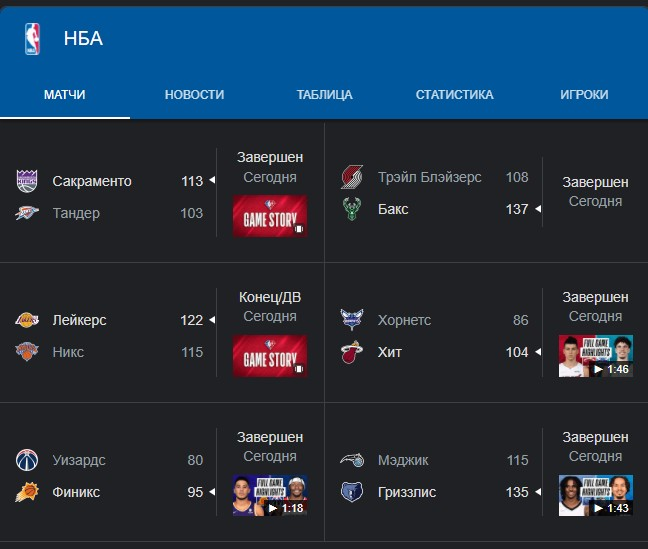

In [ ]:
from IPython.display import Image
Image(filename = "result.jpg", width=700, height=700)

In [ ]:
# Как можно наблюдать только  tab net Ошибся в  одном из  шести  матчей! все остальные  модели отлично справились с  задачей 
# Считаю поставленую Задачу  выполненой !